# Distribution Analysis for scGPT Fine-tuning: Training vs Testing Data

This notebook analyzes the distribution differences between training and testing data in the scGPT fine-tuning pipeline to investigate potential out-of-distribution (OOD) issues that might affect model generalization.

## Overview
- **Goal**: Verify if fine-tuning performance issues are due to distribution shifts between train/test data
- **Dataset**: Adamson perturbation data with simulation split
- **Analysis**: Statistical and visual comparison of gene expression patterns, perturbation effects, and cell characteristics


In [1]:
# Setup and Installation for Google Colab
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/GitHub/Biological-Foundation-Model/Notebooks/scGPT_finetune')

# Install required packages
%pip install -r ./requirements.txt
# %pip install scgpt "flash-attn<1.0.5"
# %pip install seaborn plotly scipy


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [4]:
# Import libraries
import json
import os
import sys
import time
import copy
from pathlib import Path
from typing import Iterable, List, Tuple, Dict, Union, Optional
import warnings

import matplotlib
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import pairwise_distances
from torch import nn
from torch.nn import functional as F
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
from torch_geometric.loader import DataLoader
from gears import PertData, GEARS
from gears.inference import compute_metrics, deeper_analysis, non_dropout_analysis
from gears.utils import create_cell_graph_dataset_for_prediction

sys.path.insert(0, "../")

import scgpt as scg
from scgpt.model import TransformerGenerator
from scgpt.loss import (
    masked_mse_loss,
    criterion_neg_log_bernoulli,
    masked_relative_error,
)
from scgpt.tokenizer import tokenize_batch, pad_batch, tokenize_and_pad_batch
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.utils import set_seed, map_raw_id_to_vocab_id, compute_perturbation_metrics

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
matplotlib.rcParams["savefig.transparent"] = False
warnings.filterwarnings("ignore")

set_seed(42)
print("Libraries imported successfully!")


/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


Libraries imported successfully!


In [5]:
# Load and prepare data
print("Loading perturbation data...")

# Settings for data processing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
pad_value = 0
pert_pad_id = 0
include_zero_gene = "all"
max_seq_len = 1536

# Dataset settings
data_name = "adamson"
split = "simulation"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load perturbation data
pert_data = PertData("./data")
pert_data.load(data_name=data_name)
pert_data.prepare_split(split=split, seed=1)
pert_data.get_dataloader(batch_size=64, test_batch_size=64)

print(f"Data loaded successfully!")
print(f"Dataset: {data_name}")
print(f"Split: {split}")
print(f"Device: {device}")

# Get basic info about the dataset
adata = pert_data.adata
print(f"\nDataset info:")
print(f"Total cells: {adata.n_obs}")
print(f"Total genes: {adata.n_vars}")
print(f"Conditions: {adata.obs['condition'].unique()}")
print(f"Split composition: {pert_data.subgroup}")


Found local copy...


Loading perturbation data...


Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:22
Done!
Creating dataloaders....
Done!


Data loaded successfully!
Dataset: adamson
Split: simulation
Device: cuda

Dataset info:
Total cells: 68603
Total genes: 5060
Conditions: ['CREB1+ctrl', 'ctrl', 'ZNF326+ctrl', 'BHLHE40+ctrl', 'DDIT3+ctrl', ..., 'CARS+ctrl', 'TMED2+ctrl', 'P4HB+ctrl', 'SPCS3+ctrl', 'SPCS2+ctrl']
Length: 87
Categories (88, object): ['AARS+ctrl', 'AMIGO3+ctrl', 'ARHGAP22+ctrl', 'ASCC3+ctrl', ...,
                          'XRN1+ctrl', 'YIPF5+ctrl', 'ZNF326+ctrl', 'ctrl']
Split composition: {'test_subgroup': {'combo_seen0': [], 'combo_seen1': [], 'combo_seen2': [], 'unseen_single': ['CREB1+ctrl', 'BHLHE40+ctrl', 'IER3IP1+ctrl', 'DAD1+ctrl', 'AMIGO3+ctrl', 'DARS+ctrl', 'SYVN1+ctrl', 'GMPPB+ctrl', 'CAD+ctrl', 'GNPNAT1+ctrl', 'DERL2+ctrl', 'FARSB+ctrl', 'TARS+ctrl', 'TTI1+ctrl', 'TIMM44+ctrl', 'PTDSS1+ctrl', 'DDOST+ctrl', 'CHERP+ctrl', 'COPZ1+ctrl', 'DNAJC19+ctrl', 'XRN1+ctrl', 'SPCS2+ctrl']}, 'val_subgroup': {'combo_seen0': [], 'combo_seen1': [], 'combo_seen2': [], 'unseen_single': ['EIF2B4+ctrl', 'DDRGK1+ct

In [6]:
# Extract train/test splits using the same approach as the tutorial
print("Extracting split data using GEARS approach...")

# Method 1: Use set2conditions (same as tutorial approach)
if hasattr(pert_data, 'set2conditions') and pert_data.set2conditions is not None:
    print("Using set2conditions to extract split data...")

    def extract_split_data_by_conditions(adata, set2conditions, split_name):
        """Extract data for a specific split based on conditions"""
        if split_name not in set2conditions:
            raise ValueError(f"Unknown split: {split_name}")

        # Get conditions for this split
        split_conditions = set2conditions[split_name]

        # Create boolean mask for cells in this split
        split_mask = adata.obs['condition'].isin(split_conditions)

        return adata[split_mask].copy()

    try:
        train_adata = extract_split_data_by_conditions(adata, pert_data.set2conditions, "train")
        test_adata = extract_split_data_by_conditions(adata, pert_data.set2conditions, "test")
        val_adata = extract_split_data_by_conditions(adata, pert_data.set2conditions, "val")

        print(f"Split sizes:")
        print(f"Train: {train_adata.n_obs} cells")
        print(f"Test: {test_adata.n_obs} cells")
        print(f"Val: {val_adata.n_obs} cells")

        # Get condition distributions
        print(f"\nCondition distributions:")
        print(f"Train conditions: {train_adata.obs['condition'].value_counts()}")
        print(f"Test conditions: {test_adata.obs['condition'].value_counts()}")
        print(f"Val conditions: {val_adata.obs['condition'].value_counts()}")

    except Exception as e:
        print(f"Error with set2conditions approach: {e}")
        train_adata = None
        test_adata = None
        val_adata = None

Extracting split data using GEARS approach...
Using set2conditions to extract split data...
Split sizes:
Train: 54359 cells
Test: 11363 cells
Val: 2881 cells

Condition distributions:
Train conditions: condition
ctrl             24263
YIPF5+ctrl        1182
SCYL1+ctrl        1024
HSPA5+ctrl        1002
SEC61A1+ctrl       962
IARS2+ctrl         923
GBF1+ctrl          786
HSPA9+ctrl         718
SAMM50+ctrl        672
TIMM23+ctrl        625
SRPRB+ctrl         596
UFM1+ctrl          591
SRP68+ctrl         583
MRPL39+ctrl        582
FECH+ctrl          570
TELO2+ctrl         562
SEC63+ctrl         557
SLMO2+ctrl         552
ATP5B+ctrl         547
IDH3A+ctrl         540
SPCS3+ctrl         536
TMED10+ctrl        534
TTI2+ctrl          530
SEC61G+ctrl        530
ASCC3+ctrl         524
OST4+ctrl          524
SLC35B1+ctrl       523
SLC39A7+ctrl       518
ZNF326+ctrl        517
EIF2B2+ctrl        508
SRPR+ctrl          506
PDIA6+ctrl         505
PSMD4+ctrl         488
MRGBP+ctrl         487
UFL1+c

In [7]:
# 1. Gene Expression Distribution Analysis
print("=== GENE EXPRESSION DISTRIBUTION ANALYSIS ===")

def analyze_gene_expression_distribution(adata, split_name):
    """Analyze gene expression distribution for a split"""
    # Convert to dense if sparse
    if hasattr(adata.X, 'toarray'):
        X = adata.X.toarray()
    else:
        X = adata.X

    # Calculate statistics
    mean_expr = np.mean(X, axis=0)
    std_expr = np.std(X, axis=0)
    var_expr = np.var(X, axis=0)

    # Calculate per-cell statistics
    cell_means = np.mean(X, axis=1)
    cell_stds = np.std(X, axis=1)
    cell_zeros = np.sum(X == 0, axis=1) / X.shape[1]  # fraction of zeros per cell

    return {
        'gene_means': mean_expr,
        'gene_stds': std_expr,
        'gene_vars': var_expr,
        'cell_means': cell_means,
        'cell_stds': cell_stds,
        'cell_zeros': cell_zeros,
        'total_expression': np.sum(X, axis=1),
        'n_genes_expressed': np.sum(X > 0, axis=1)
    }

# Analyze each split
train_stats = analyze_gene_expression_distribution(train_adata, "train")
test_stats = analyze_gene_expression_distribution(test_adata, "test")
val_stats = analyze_gene_expression_distribution(val_adata, "val")

print(f"Gene expression statistics calculated for all splits")


=== GENE EXPRESSION DISTRIBUTION ANALYSIS ===
Gene expression statistics calculated for all splits


In [8]:
print(train_stats['cell_means'].mean())
print(test_stats['cell_means'].mean())

0.2510287
0.25758225


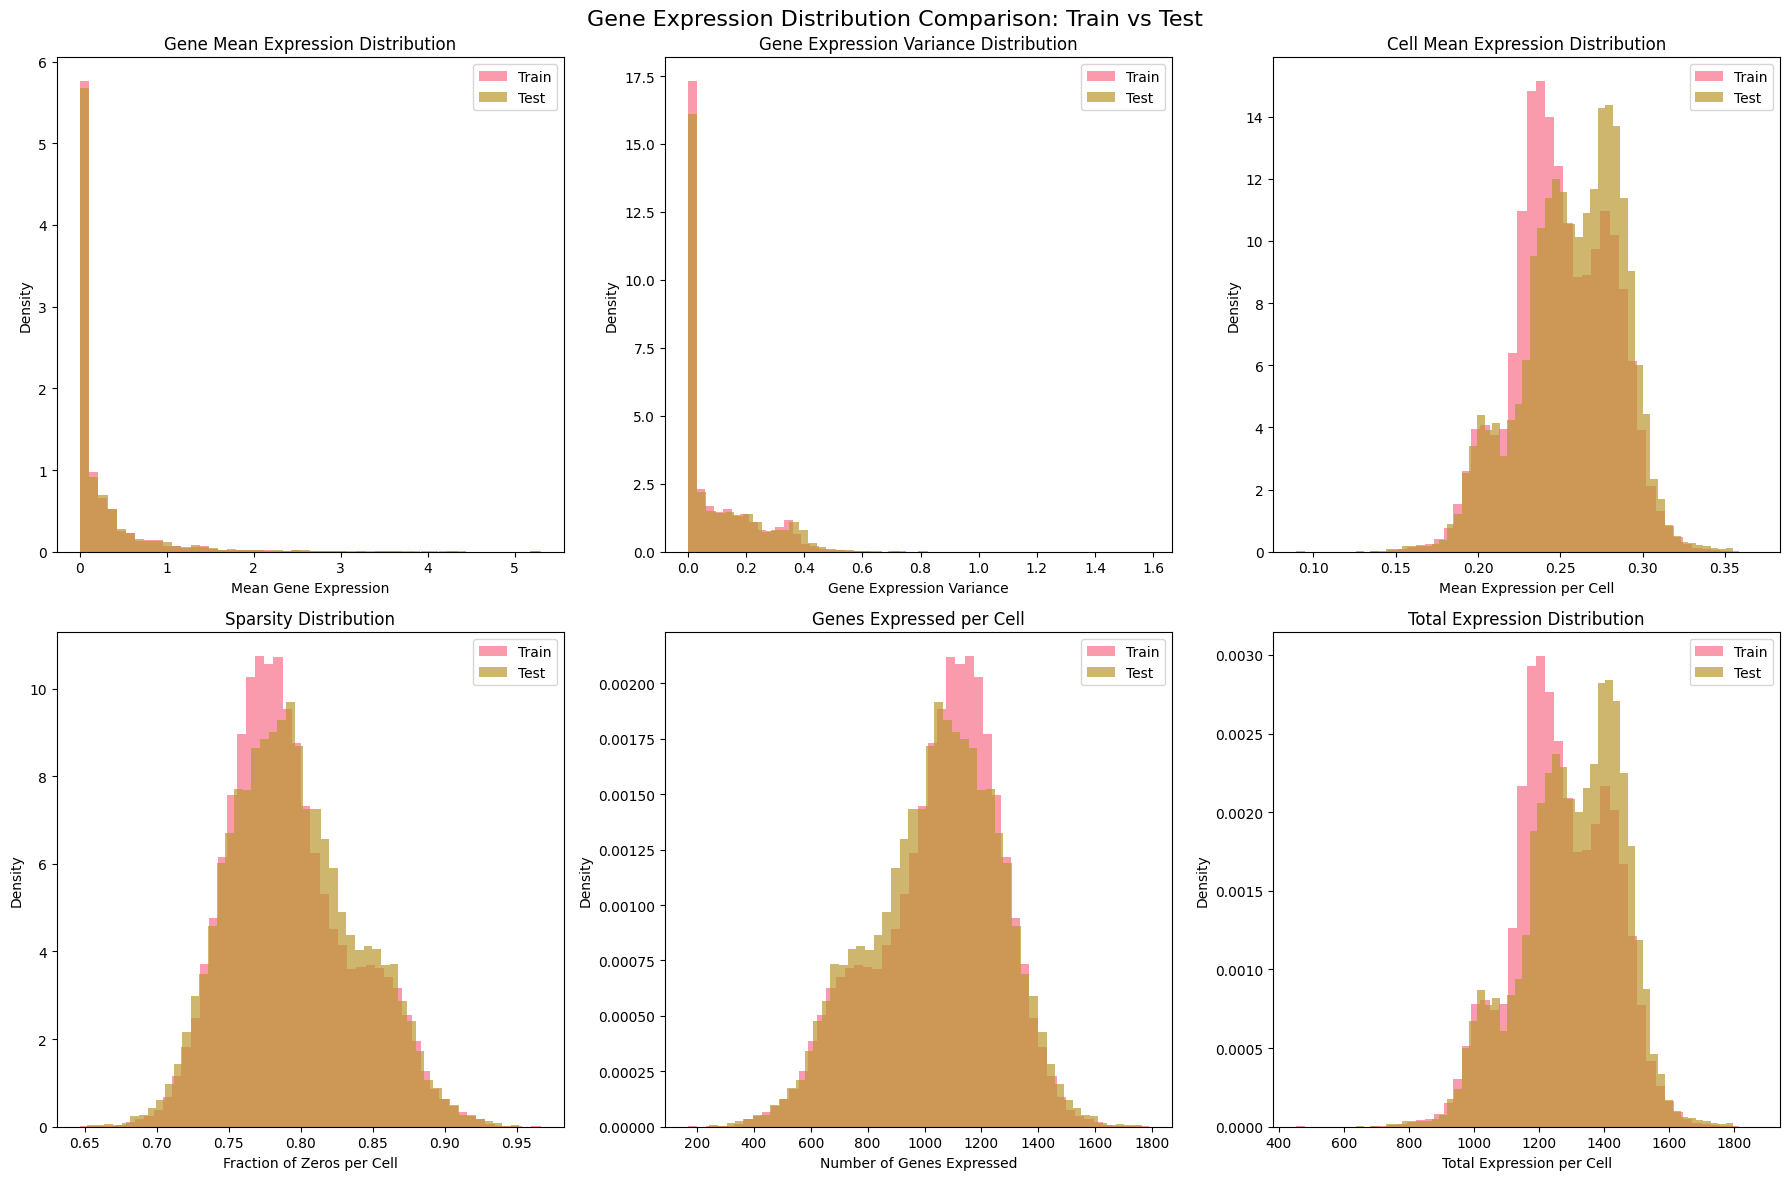

In [9]:
# Visualize gene expression distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Gene Expression Distribution Comparison: Train vs Test', fontsize=16)

# 1. Gene mean expression
axes[0, 0].hist(train_stats['gene_means'], bins=50, alpha=0.7, label='Train', density=True)
axes[0, 0].hist(test_stats['gene_means'], bins=50, alpha=0.7, label='Test', density=True)
axes[0, 0].set_xlabel('Mean Gene Expression')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Gene Mean Expression Distribution')
axes[0, 0].legend()

# 2. Gene expression variance
axes[0, 1].hist(train_stats['gene_vars'], bins=50, alpha=0.7, label='Train', density=True)
axes[0, 1].hist(test_stats['gene_vars'], bins=50, alpha=0.7, label='Test', density=True)
axes[0, 1].set_xlabel('Gene Expression Variance')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Gene Expression Variance Distribution')
axes[0, 1].legend()

# 3. Cell mean expression
axes[0, 2].hist(train_stats['cell_means'], bins=50, alpha=0.7, label='Train', density=True)
axes[0, 2].hist(test_stats['cell_means'], bins=50, alpha=0.7, label='Test', density=True)
axes[0, 2].set_xlabel('Mean Expression per Cell')
axes[0, 2].set_ylabel('Density')
axes[0, 2].set_title('Cell Mean Expression Distribution')
axes[0, 2].legend()

# 4. Fraction of zeros per cell
axes[1, 0].hist(train_stats['cell_zeros'], bins=50, alpha=0.7, label='Train', density=True)
axes[1, 0].hist(test_stats['cell_zeros'], bins=50, alpha=0.7, label='Test', density=True)
axes[1, 0].set_xlabel('Fraction of Zeros per Cell')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Sparsity Distribution')
axes[1, 0].legend()

# 5. Number of genes expressed per cell
axes[1, 1].hist(train_stats['n_genes_expressed'], bins=50, alpha=0.7, label='Train', density=True)
axes[1, 1].hist(test_stats['n_genes_expressed'], bins=50, alpha=0.7, label='Test', density=True)
axes[1, 1].set_xlabel('Number of Genes Expressed')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Genes Expressed per Cell')
axes[1, 1].legend()

# 6. Total expression per cell
axes[1, 2].hist(train_stats['total_expression'], bins=50, alpha=0.7, label='Train', density=True)
axes[1, 2].hist(test_stats['total_expression'], bins=50, alpha=0.7, label='Test', density=True)
axes[1, 2].set_xlabel('Total Expression per Cell')
axes[1, 2].set_ylabel('Density')
axes[1, 2].set_title('Total Expression Distribution')
axes[1, 2].legend()

plt.tight_layout()
plt.show()


In [10]:
# Statistical tests for distribution differences
print("=== STATISTICAL TESTS FOR DISTRIBUTION DIFFERENCES ===")

def perform_statistical_tests(train_stats, test_stats, metric_name):
    """Perform statistical tests comparing train and test distributions"""
    train_data = train_stats[metric_name]
    test_data = test_stats[metric_name]

    # Kolmogorov-Smirnov test
    ks_stat, ks_pvalue = stats.ks_2samp(train_data, test_data)

    # Mann-Whitney U test (non-parametric)
    mw_stat, mw_pvalue = stats.mannwhitneyu(train_data, test_data, alternative='two-sided')

    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(train_data) - 1) * np.var(train_data) +
                         (len(test_data) - 1) * np.var(test_data)) /
                        (len(train_data) + len(test_data) - 2))
    cohens_d = (np.mean(train_data) - np.mean(test_data)) / pooled_std

    return {
        'ks_stat': ks_stat,
        'ks_pvalue': ks_pvalue,
        'mw_stat': mw_stat,
        'mw_pvalue': mw_pvalue,
        'cohens_d': cohens_d,
        'train_mean': np.mean(train_data),
        'test_mean': np.mean(test_data),
        'train_std': np.std(train_data),
        'test_std': np.std(test_data)
    }

# Test different metrics
metrics_to_test = ['gene_means', 'gene_vars', 'cell_means', 'cell_zeros',
                   'n_genes_expressed', 'total_expression']

statistical_results = {}
for metric in metrics_to_test:
    print(f"\nTesting {metric}:")
    results = perform_statistical_tests(train_stats, test_stats, metric)
    statistical_results[metric] = results

    print(f"  Train mean: {results['train_mean']:.4f} ± {results['train_std']:.4f}")
    print(f"  Test mean:  {results['test_mean']:.4f} ± {results['test_std']:.4f}")
    print(f"  Cohen's d:  {results['cohens_d']:.4f}")
    print(f"  KS test:    stat={results['ks_stat']:.4f}, p={results['ks_pvalue']:.4f}")
    print(f"  MW test:    stat={results['mw_stat']:.4f}, p={results['mw_pvalue']:.4f}")

    # Interpretation
    if results['ks_pvalue'] < 0.05:
        print(f"  *** SIGNIFICANT DIFFERENCE (KS test, p < 0.05) ***")
    if abs(results['cohens_d']) > 0.2:
        effect_size = "small" if abs(results['cohens_d']) < 0.5 else "medium" if abs(results['cohens_d']) < 0.8 else "large"
        print(f"  *** {effect_size.upper()} EFFECT SIZE (Cohen's d = {results['cohens_d']:.3f}) ***")


=== STATISTICAL TESTS FOR DISTRIBUTION DIFFERENCES ===

Testing gene_means:
  Train mean: 0.2510 ± 0.5282
  Test mean:  0.2576 ± 0.5292
  Cohen's d:  -0.0124
  KS test:    stat=0.0200, p=0.2658
  MW test:    stat=12592089.5000, p=0.1536

Testing gene_vars:
  Train mean: 0.0964 ± 0.1301
  Test mean:  0.1047 ± 0.1384
  Cohen's d:  -0.0618
  KS test:    stat=0.0291, p=0.0279
  MW test:    stat=12410996.0000, p=0.0078
  *** SIGNIFICANT DIFFERENCE (KS test, p < 0.05) ***

Testing cell_means:
  Train mean: 0.2510 ± 0.0296
  Test mean:  0.2576 ± 0.0305
  Cohen's d:  -0.2200
  KS test:    stat=0.1283, p=0.0000
  MW test:    stat=265042435.0000, p=0.0000
  *** SIGNIFICANT DIFFERENCE (KS test, p < 0.05) ***
  *** SMALL EFFECT SIZE (Cohen's d = -0.220) ***

Testing cell_zeros:
  Train mean: 0.7926 ± 0.0431
  Test mean:  0.7949 ± 0.0446
  Cohen's d:  -0.0525
  KS test:    stat=0.0511, p=0.0000
  MW test:    stat=297259677.5000, p=0.0000
  *** SIGNIFICANT DIFFERENCE (KS test, p < 0.05) ***

Testing

In [11]:
# 2. Perturbation Pattern Analysis
print("\n=== PERTURBATION PATTERN ANALYSIS ===")

def analyze_perturbation_patterns(train_adata, test_adata):
    """Analyze perturbation patterns between train and test sets"""

    # Get perturbation conditions (exclude control)
    train_conditions = train_adata.obs['condition'].value_counts()
    test_conditions = test_adata.obs['condition'].value_counts()

    # Get unique perturbations
    train_perts = set(train_conditions.index) - {'ctrl'}
    test_perts = set(test_conditions.index) - {'ctrl'}

    # Analyze perturbation overlap
    common_perts = train_perts.intersection(test_perts)
    train_only = train_perts - test_perts
    test_only = test_perts - train_perts

    # Analyze perturbation types
    def categorize_perturbation(pert_name):
        if '+' in pert_name:
            return 'combinatorial'
        else:
            return 'single'

    train_pert_types = [categorize_perturbation(p) for p in train_perts]
    test_pert_types = [categorize_perturbation(p) for p in test_perts]

    return {
        'train_conditions': train_conditions,
        'test_conditions': test_conditions,
        'common_perts': common_perts,
        'train_only': train_only,
        'test_only': test_only,
        'train_pert_types': train_pert_types,
        'test_pert_types': test_pert_types,
        'train_single_count': train_pert_types.count('single'),
        'train_combo_count': train_pert_types.count('combinatorial'),
        'test_single_count': test_pert_types.count('single'),
        'test_combo_count': test_pert_types.count('combinatorial')
    }

pert_analysis = analyze_perturbation_patterns(train_adata, test_adata)

print(f"Perturbation overlap analysis:")
print(f"  Common perturbations: {len(pert_analysis['common_perts'])}")
print(f"  Train-only perturbations: {len(pert_analysis['train_only'])}")
print(f"  Test-only perturbations: {len(pert_analysis['test_only'])}")

print(f"\nPerturbation type distribution:")
print(f"  Train - Single: {pert_analysis['train_single_count']}, Combinatorial: {pert_analysis['train_combo_count']}")
print(f"  Test - Single: {pert_analysis['test_single_count']}, Combinatorial: {pert_analysis['test_combo_count']}")

print(f"\nTest-only perturbations: {list(pert_analysis['test_only'])}")
print(f"Train-only perturbations: {list(pert_analysis['train_only'])}")



=== PERTURBATION PATTERN ANALYSIS ===
Perturbation overlap analysis:
  Common perturbations: 0
  Train-only perturbations: 57
  Test-only perturbations: 22

Perturbation type distribution:
  Train - Single: 0, Combinatorial: 57
  Test - Single: 0, Combinatorial: 22

Test-only perturbations: ['BHLHE40+ctrl', 'DAD1+ctrl', 'TARS+ctrl', 'DNAJC19+ctrl', 'DDOST+ctrl', 'TIMM44+ctrl', 'GNPNAT1+ctrl', 'SPCS2+ctrl', 'DERL2+ctrl', 'TTI1+ctrl', 'XRN1+ctrl', 'AMIGO3+ctrl', 'COPZ1+ctrl', 'PTDSS1+ctrl', 'DARS+ctrl', 'FARSB+ctrl', 'GMPPB+ctrl', 'CREB1+ctrl', 'IER3IP1+ctrl', 'CHERP+ctrl', 'SYVN1+ctrl', 'CAD+ctrl']
Train-only perturbations: ['STT3A+ctrl', 'SRP72+ctrl', 'QARS+ctrl', 'SPCS3+ctrl', 'SCYL1+ctrl', 'NEDD8+ctrl', 'TMEM167A+ctrl', 'COPB1+ctrl', 'SRPRB+ctrl', 'TMED2+ctrl', 'PPWD1+ctrl', 'MTHFD1+ctrl', 'CARS+ctrl', 'SAMM50+ctrl', 'HYOU1+ctrl', 'UFL1+ctrl', 'TTI2+ctrl', 'SEC61G+ctrl', 'EIF2B2+ctrl', 'SRPR+ctrl', 'ARHGAP22+ctrl', 'AARS+ctrl', 'ASCC3+ctrl', 'HSPA9+ctrl', 'KCTD16+ctrl', 'TELO2+ctrl'

In [ ]:
# 3. Dimensionality Reduction Analysis
print("\n=== DIMENSIONALITY REDUCTION ANALYSIS ===")
import umap

def perform_dimensionality_reduction(adata, method='PCA', n_components=50):
    """Perform dimensionality reduction on gene expression data"""
    # Convert to dense if sparse
    if hasattr(adata.X, 'toarray'):
        X = adata.X.toarray()
    else:
        X = adata.X

    if method == 'PCA':
        reducer = PCA(n_components=n_components, random_state=42)
    elif method == 'tSNE':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    else:
        raise ValueError(f"Unknown method: {method}")

    embedding = reducer.fit_transform(X)
    return embedding, reducer

# Perform PCA on each split
print("Computing PCA embeddings...")
train_pca, train_pca_model = perform_dimensionality_reduction(train_adata, 'PCA', 50)
test_pca, test_pca_model = perform_dimensionality_reduction(test_adata, 'PCA', 50)
val_pca, val_pca_model = perform_dimensionality_reduction(val_adata, 'PCA', 50)

# Perform t-SNE on combined data for visualization
print("Computing t-SNE embedding...")
combined_adata = train_adata.concatenate([test_adata, val_adata],
                                        batch_key='split',
                                        batch_categories=['train', 'test', 'val'])
combined_tsne, _ = perform_dimensionality_reduction(combined_adata, 'tSNE', 2)

print(f"PCA explained variance ratios (first 10 components):")
print(f"  Train: {train_pca_model.explained_variance_ratio_[:10]}")
print(f"  Test:  {test_pca_model.explained_variance_ratio_[:10]}")
print(f"  Val:   {val_pca_model.explained_variance_ratio_[:10]}")


In [15]:
# === UMAP on COMBINED dataset ===
print("\n=== UMAP on COMBINED dataset ===")

from scipy.sparse import issparse
from sklearn.decomposition import PCA, TruncatedSVD
import umap
import numpy as np

# 1) Concatenate splits (same API you used before)
combined_adata = train_adata.concatenate(
    [test_adata, val_adata],
    batch_key='split',
    batch_categories=['train', 'test', 'val']
)

# 2) PCA/SVD on combined (no densify if sparse)
X = combined_adata.X
n_pcs = 50
if issparse(X):
    pca_model = TruncatedSVD(n_components=n_pcs, random_state=42)
else:
    pca_model = PCA(n_components=n_pcs, svd_solver='randomized', random_state=42)

print("Fitting PCA/SVD on combined data...")
combined_pcs = pca_model.fit_transform(X)
combined_adata.obsm['X_pca'] = combined_pcs

# 3) UMAP on combined PCs
print("Fitting UMAP on combined PCs...")
um = umap.UMAP(
    n_neighbors=30,     # tweak 15–50
    min_dist=0.3,       # tweak 0.1–0.5
    n_components=2,
    metric='euclidean', # with PCA features, euclidean is fine
    random_state=42
)
combined_umap = um.fit_transform(combined_pcs)
combined_adata.obsm['X_umap'] = combined_umap

# 4) Quick report
evr = getattr(pca_model, "explained_variance_ratio_", None)
if evr is not None:
    print("Combined PCA EVR (first 10):", evr[:10])
print("Shapes — PCs:", combined_pcs.shape, "UMAP:", combined_umap.shape)
print("Done. Embeddings stored in combined_adata.obsm['X_pca'] and ['X_umap'].")



=== UMAP on COMBINED dataset ===
Fitting PCA/SVD on combined data...
Fitting UMAP on combined PCs...
Combined PCA EVR (first 10): [0.00901966 0.03824009 0.02752348 0.01831881 0.01479116 0.01106845
 0.00939826 0.00800205 0.00745818 0.00694167]
Shapes — PCs: (68603, 50) UMAP: (68603, 2)
Done. Embeddings stored in combined_adata.obsm['X_pca'] and ['X_umap'].


In [19]:
combined_adata.obsm['X_umap']

array([[ 9.018619 , 10.027452 ],
       [ 9.502616 , 10.165359 ],
       [10.377277 , 11.247536 ],
       ...,
       [ 2.672172 , -1.0646205],
       [ 1.9626677, -2.6348827],
       [ 4.9926167, -2.0956795]], dtype=float32)

NameError: name 'train_pca_model' is not defined

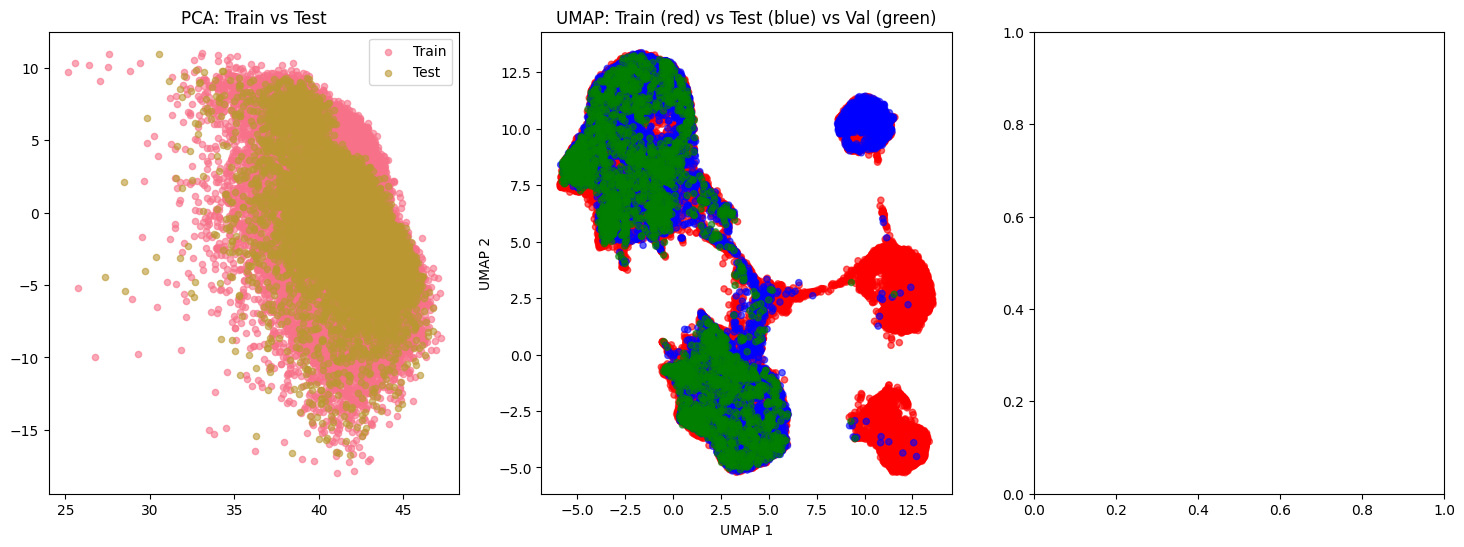

In [25]:
# Visualize dimensionality reduction results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. PCA comparison (first 2 components)
axes[0].scatter(train_pca[:, 0], train_pca[:, 1], alpha=0.6, label='Train', s=20)
axes[0].scatter(test_pca[:, 0], test_pca[:, 1], alpha=0.6, label='Test', s=20)
# axes[0].set_xlabel(f'PC1 ({train_pca_model.explained_variance_ratio_[0]:.2%} variance)')
# axes[0].set_ylabel(f'PC2 ({train_pca_model.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title('PCA: Train vs Test')
axes[0].legend()

# 2. t-SNE visualization
split_colors = ['red' if s == 'train' else 'blue' if s == 'test' else 'green' for s in combined_adata.obs['split']]
axes[1].scatter(combined_adata.obsm['X_umap'][:, 0], combined_adata.obsm['X_umap'][:, 1], c=split_colors, alpha=0.6, s=20)
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')
axes[1].set_title('UMAP: Train (red) vs Test (blue) vs Val (green)')

# 3. PCA variance explained
axes[2].plot(range(1, 11), train_pca_model.explained_variance_ratio_[:10], 'o-', label='Train')
axes[2].plot(range(1, 11), test_pca_model.explained_variance_ratio_[:10], 's-', label='Test')
axes[2].set_xlabel('Principal Component')
axes[2].set_ylabel('Explained Variance Ratio')
axes[2].set_title('PCA Explained Variance')
axes[2].legend()

plt.tight_layout()
plt.show()



=== DISTANCE-BASED ANALYSIS ===
Computing distance matrices...


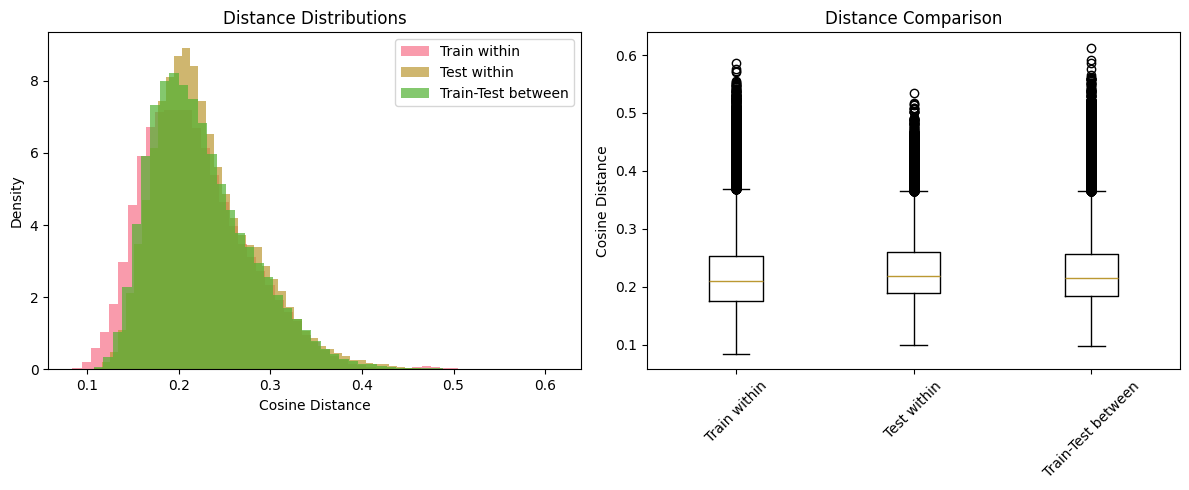

Distance statistics:
  Train within: 0.2186 ± 0.0586
  Test within:  0.2287 ± 0.0545
  Between:      0.2245 ± 0.0555

KS test (train within vs between): stat=0.0632, p=0.0000
*** SIGNIFICANT DIFFERENCE in distance distributions ***


In [22]:
# 4. Distance-based Analysis
print("\n=== DISTANCE-BASED ANALYSIS ===")

def compute_distances_between_splits(train_adata, test_adata, n_samples=1000):
    """Compute distances between train and test splits"""

    # Sample cells for computational efficiency
    if train_adata.n_obs > n_samples:
        train_indices = np.random.choice(train_adata.n_obs, n_samples, replace=False)
        train_sample = train_adata[train_indices]
    else:
        train_sample = train_adata

    if test_adata.n_obs > n_samples:
        test_indices = np.random.choice(test_adata.n_obs, n_samples, replace=False)
        test_sample = test_adata[test_indices]
    else:
        test_sample = test_adata

    # Convert to dense matrices
    if hasattr(train_sample.X, 'toarray'):
        train_X = train_sample.X.toarray()
        test_X = test_sample.X.toarray()
    else:
        train_X = train_sample.X
        test_X = test_sample.X

    # Compute pairwise distances within each split
    train_distances = pairwise_distances(train_X, metric='cosine')
    test_distances = pairwise_distances(test_X, metric='cosine')

    # Compute distances between splits
    between_distances = pairwise_distances(train_X, test_X, metric='cosine')

    return {
        'train_within': train_distances[np.triu_indices_from(train_distances, k=1)],
        'test_within': test_distances[np.triu_indices_from(test_distances, k=1)],
        'between': between_distances.flatten()
    }

print("Computing distance matrices...")
distances = compute_distances_between_splits(train_adata, test_adata, n_samples=500)

# Visualize distance distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distance distributions
axes[0].hist(distances['train_within'], bins=50, alpha=0.7, label='Train within', density=True)
axes[0].hist(distances['test_within'], bins=50, alpha=0.7, label='Test within', density=True)
axes[0].hist(distances['between'], bins=50, alpha=0.7, label='Train-Test between', density=True)
axes[0].set_xlabel('Cosine Distance')
axes[0].set_ylabel('Density')
axes[0].set_title('Distance Distributions')
axes[0].legend()

# Box plot comparison
data_to_plot = [distances['train_within'], distances['test_within'], distances['between']]
labels = ['Train within', 'Test within', 'Train-Test between']
axes[1].boxplot(data_to_plot, labels=labels)
axes[1].set_ylabel('Cosine Distance')
axes[1].set_title('Distance Comparison')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Statistical comparison
print(f"Distance statistics:")
print(f"  Train within: {np.mean(distances['train_within']):.4f} ± {np.std(distances['train_within']):.4f}")
print(f"  Test within:  {np.mean(distances['test_within']):.4f} ± {np.std(distances['test_within']):.4f}")
print(f"  Between:      {np.mean(distances['between']):.4f} ± {np.std(distances['between']):.4f}")

# Test if between-split distances are significantly different
ks_stat, ks_pvalue = stats.ks_2samp(distances['train_within'], distances['between'])
print(f"\nKS test (train within vs between): stat={ks_stat:.4f}, p={ks_pvalue:.4f}")
if ks_pvalue < 0.05:
    print("*** SIGNIFICANT DIFFERENCE in distance distributions ***")


In [23]:
# 5. Summary and Conclusions
print("\n=== SUMMARY AND CONCLUSIONS ===")

def generate_summary_report(statistical_results, pert_analysis, distances):
    """Generate a comprehensive summary report"""

    print("DISTRIBUTION ANALYSIS SUMMARY")
    print("=" * 50)

    # Gene expression differences
    print("\n1. GENE EXPRESSION DISTRIBUTION DIFFERENCES:")
    significant_diffs = []
    for metric, results in statistical_results.items():
        if results['ks_pvalue'] < 0.05:
            significant_diffs.append(metric)
            effect_size = "small" if abs(results['cohens_d']) < 0.5 else "medium" if abs(results['cohens_d']) < 0.8 else "large"
            print(f"   - {metric}: SIGNIFICANT (p={results['ks_pvalue']:.4f}, {effect_size} effect, d={results['cohens_d']:.3f})")
        else:
            print(f"   - {metric}: Not significant (p={results['ks_pvalue']:.4f})")

    # Perturbation analysis
    print(f"\n2. PERTURBATION PATTERN ANALYSIS:")
    print(f"   - Common perturbations: {len(pert_analysis['common_perts'])}")
    print(f"   - Test-only perturbations: {len(pert_analysis['test_only'])}")
    print(f"   - Train-only perturbations: {len(pert_analysis['train_only'])}")

    if len(pert_analysis['test_only']) > 0:
        print(f"   - *** OUT-OF-DISTRIBUTION TESTING: {len(pert_analysis['test_only'])} perturbations not seen in training ***")

    # Distance analysis
    print(f"\n3. DISTANCE-BASED ANALYSIS:")
    train_within_mean = np.mean(distances['train_within'])
    test_within_mean = np.mean(distances['test_within'])
    between_mean = np.mean(distances['between'])

    print(f"   - Train within-cluster distance: {train_within_mean:.4f}")
    print(f"   - Test within-cluster distance: {test_within_mean:.4f}")
    print(f"   - Train-Test between-cluster distance: {between_mean:.4f}")

    if between_mean > max(train_within_mean, test_within_mean) * 1.2:
        print(f"   - *** SIGNIFICANT SEPARATION: Train and test clusters are well-separated ***")

    # Overall conclusion
    print(f"\n4. OVERALL ASSESSMENT:")
    ood_indicators = []

    if len(significant_diffs) > 0:
        ood_indicators.append(f"Gene expression differences ({len(significant_diffs)} metrics)")

    if len(pert_analysis['test_only']) > 0:
        ood_indicators.append(f"Novel perturbations in test set ({len(pert_analysis['test_only'])} perturbations)")

    if between_mean > max(train_within_mean, test_within_mean) * 1.2:
        ood_indicators.append("Well-separated train/test clusters")

    if ood_indicators:
        print(f"   *** EVIDENCE OF OUT-OF-DISTRIBUTION TESTING:")
        for indicator in ood_indicators:
            print(f"      - {indicator}")
        print(f"\n   *** CONCLUSION: Fine-tuning performance issues likely due to OOD testing ***")
    else:
        print(f"   *** CONCLUSION: Limited evidence of OOD issues - other factors may be responsible ***")

    return {
        'significant_diffs': significant_diffs,
        'ood_indicators': ood_indicators,
        'is_ood': len(ood_indicators) > 0
    }

# Generate summary
summary = generate_summary_report(statistical_results, pert_analysis, distances)



=== SUMMARY AND CONCLUSIONS ===
DISTRIBUTION ANALYSIS SUMMARY

1. GENE EXPRESSION DISTRIBUTION DIFFERENCES:
   - gene_means: Not significant (p=0.2658)
   - gene_vars: SIGNIFICANT (p=0.0279, small effect, d=-0.062)
   - cell_means: SIGNIFICANT (p=0.0000, small effect, d=-0.220)
   - cell_zeros: SIGNIFICANT (p=0.0000, small effect, d=-0.052)
   - n_genes_expressed: SIGNIFICANT (p=0.0000, small effect, d=0.052)
   - total_expression: SIGNIFICANT (p=0.0000, small effect, d=-0.220)

2. PERTURBATION PATTERN ANALYSIS:
   - Common perturbations: 0
   - Test-only perturbations: 22
   - Train-only perturbations: 57
   - *** OUT-OF-DISTRIBUTION TESTING: 22 perturbations not seen in training ***

3. DISTANCE-BASED ANALYSIS:
   - Train within-cluster distance: 0.2186
   - Test within-cluster distance: 0.2287
   - Train-Test between-cluster distance: 0.2245

4. OVERALL ASSESSMENT:
   *** EVIDENCE OF OUT-OF-DISTRIBUTION TESTING:
      - Gene expression differences (5 metrics)
      - Novel perturba

In [24]:
# Save results for further analysis
print("\n=== SAVING RESULTS ===")

# Create results directory
results_dir = Path("./distribution_analysis_results")
results_dir.mkdir(exist_ok=True)

# Save statistical results
import json
with open(results_dir / "statistical_results.json", "w") as f:
    # Convert numpy types to Python types for JSON serialization
    json_results = {}
    for metric, results in statistical_results.items():
        json_results[metric] = {k: float(v) if isinstance(v, (np.integer, np.floating)) else v
                               for k, v in results.items()}
    json.dump(json_results, f, indent=2)

# Save perturbation analysis
pert_json = {
    'common_perts': list(pert_analysis['common_perts']),
    'train_only': list(pert_analysis['train_only']),
    'test_only': list(pert_analysis['test_only']),
    'train_single_count': pert_analysis['train_single_count'],
    'train_combo_count': pert_analysis['train_combo_count'],
    'test_single_count': pert_analysis['test_single_count'],
    'test_combo_count': pert_analysis['test_combo_count']
}
with open(results_dir / "perturbation_analysis.json", "w") as f:
    json.dump(pert_json, f, indent=2)

# Save summary
with open(results_dir / "summary.json", "w") as f:
    json.dump(summary, f, indent=2)

# Save plots
plt.savefig(results_dir / "distribution_analysis.png", dpi=300, bbox_inches='tight')

print(f"Results saved to {results_dir}/")
print(f"Files created:")
print(f"  - statistical_results.json")
print(f"  - perturbation_analysis.json")
print(f"  - summary.json")
print(f"  - distribution_analysis.png")

print(f"\nAnalysis complete! Check the results directory for detailed outputs.")



=== SAVING RESULTS ===
Results saved to distribution_analysis_results/
Files created:
  - statistical_results.json
  - perturbation_analysis.json
  - summary.json
  - distribution_analysis.png

Analysis complete! Check the results directory for detailed outputs.


<Figure size 640x480 with 0 Axes>